# <center > PHYC90009 Assignment </center>
## <center> How much of the sky is covered by galaxies? </center> 

## Packages 

In [1]:
import numpy as np
import scipy as sp
from scipy.integrate import quad, dblquad, simps 
import matplotlib.pyplot as plt
%matplotlib inline

## Constants 


In [31]:
h_0 = 67.66 #Hubble Const from Planck
c = 299792458 #Speed of Light 
d_h0 = c/h_0 # Hubble dist at current time 
h = 0.7 #Reduced Hubble Const
om_k = 1.0 #Omega for Curvature
om_m = 0.3 #Omega Matter
om_lam = 0.7 #Omega Dark Energy
om_r = 0.0 #Omega Radiation
n = 1 
sig_8 = 0.9

### 1) a) Compute and Plot the Angular Diamter Distance as a Function of Redshift
Angular Diamter Distance $d_A$ is given 
$$ d_A = \frac{r_{em}}{1 + z}$$
Where $r_{em}$ is the comoving distance, given by 
$$ r_{em} = \int_0^z d_h dz' $$ 
z is redshift,
d_h is the Hubble Distance, given by 
$$ d_h = \frac{c}{H(z)} $$
$$ \Rightarrow d_A = \frac{c}{1+z} \int_0^z \frac{dz'}{H(z)} $$

In [32]:
z = np.arange(0,10,0.1)
def d_h(z):
    return(c/(h_0*np.sqrt(om_m*(1+z)**3 + om_lam)))

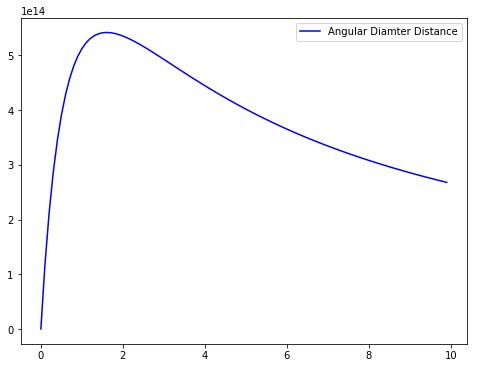

In [48]:
r_em = [(c/(1+zed)*quad(d_h,0,zed)[0]) for zed in z]
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(z,r_em,'b-',label='Angular Diamter Distance')
ax.legend(loc = 'upper right')

### 1) b) Compute and Plot the Growth Function as a Function of Redshift
The growth function as a function of redshift is given by 
$$ D(t) \propto \frac{(\Omega_\Lambda a^3 + \Omega_k a + \Omega_m)^{1/2}}{a^{3/2}} \int_0^a \frac{a'^{3/2} da'}{(\Omega_\Lambda a'^3 + \Omega_k a' + \Omega_m)^{3/2}} $$ 
where $a = \frac{1}{1+z}$

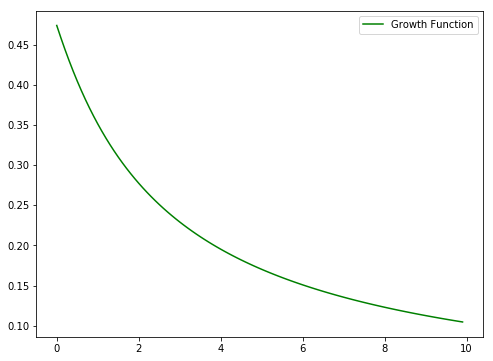

In [49]:
a = 1/(1+z)
def temp_func(a):
    return(float((a**(3./2.))/((om_lam * a**3 + om_k * a + om_m )**(3./2.))))
D_t = [np.sqrt(om_lam * ay**3 + om_k * ay + om_m )/(ay**(3/2))*quad(temp_func,0,ay)[0] for ay in a]
fig, ax = plt.subplots(figsize= (8,6))
ax.plot(z,D_t,'g-',label='Growth Function')
ax.legend(loc = 'upper right')

In [50]:
def j_1(x):
    return((np.sin(x) - x* np.cos(x))/x**2)

In [41]:
x = np.linspace(0,np.pi,1000)

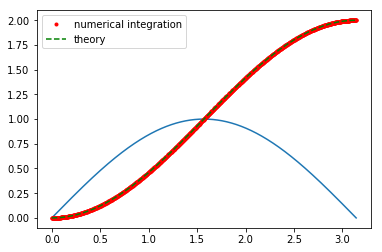

In [46]:
fig, ax = plt.subplots()
ax.plot(x,np.sin(x))
results = np.empty(len(x))

#for ii, xi in enumerate(x):
    
#    results[ii] = quad(np.sin,0,xi)[0]

results = [quad(np.sin,0,xi)[0] for xi in x]
ax.plot(x,results,'r.',label = 'numerical integration')
ax.plot(x,1-np.cos(x), 'g--',label = 'theory')

ax.legend(loc = 'upper left')

In [35]:
quad(np.sin,0,1.2)

(0.6376422455233265, 7.079251024536842e-15)